In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tstrippy
from astropy import units as u
from astropy import constants as const
import starParticlesErr1 as SPE
import datetime
import multiprocessing as mp
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

In [9]:
GCdata=tstrippy.Parsers.baumgardtMWGCs().data
np.savetxt( "GCnames.txt", GCdata['Cluster'][:],fmt='%s')

In [2]:
NP = 1000
integrationtime = 100

alphas = [2,1,1/10,1/100,1/1000,1/10000,] # number of experiments 

# for accelerating the computation 
freecpu = 2 
ncpu = mp.cpu_count()-freecpu
nbatches = ncpu 



comptime = []
streams = []
alpha_adjusted = []
errE = []
arguments = []
NSTEPS = [ ]
for i in range(len(alphas)):
    alpha = alphas[i]
    initialkinematics, staticgalaxy, integrationparameters = SPE.prepare_integration_arguments(NP, integrationtime, alpha)
    initialkinematics = np.array(initialkinematics)
    args = [initialkinematics, staticgalaxy, integrationparameters]
    start_time = datetime.datetime.now()
    stream, comptime_i = SPE.batch_leapfrogtofinalpositions(args, nbatches=nbatches, freecpu=freecpu)
    endtime = datetime.datetime.now()
    cccomptime = (endtime - start_time).total_seconds()
    print(f"Alpha: {alpha}, Computation time: {cccomptime:.2f} seconds")
    streams.append(stream)
    comptime.append(comptime_i)
    alpha_adjusted.append(integrationparameters[1])
    arguments.append(args)
    NSTEPS.append(integrationparameters[-1])

# power = int(np.log10(alpha_out))
# mantissa = alpha_out / 10**power
# dtstring = r"$\Delta t = {:.2f} \times 10^{{{:d}}}~\tau $" .format(mantissa, power)


Running 6 batches with 6 CPUs, each with 166 particles
Alpha: 2, Computation time: 0.56 seconds
Running 6 batches with 6 CPUs, each with 166 particles
Alpha: 1, Computation time: 0.56 seconds
Running 6 batches with 6 CPUs, each with 166 particles
Alpha: 0.1, Computation time: 0.56 seconds
Running 6 batches with 6 CPUs, each with 166 particles
Alpha: 0.01, Computation time: 0.78 seconds
Running 6 batches with 6 CPUs, each with 166 particles
Alpha: 0.001, Computation time: 2.44 seconds
Running 6 batches with 6 CPUs, each with 166 particles
Alpha: 0.0001, Computation time: 15.39 seconds


In [3]:
# get the error for each one 
errE = []
for i in range(len(alphas)):
    args = arguments[i]
    initialkinematics, staticgalaxy, integrationparameters = args
    Erel = SPE.realative_enery_error_final(initialkinematics, staticgalaxy, streams[i])
    errE.append(Erel)

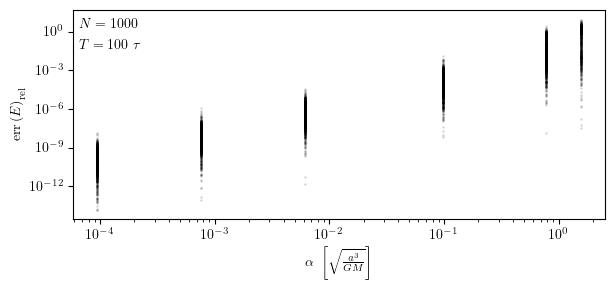

In [4]:
fig,axis= plt.subplots(figsize=(8.25-2, 3))
bins = np.logspace(-16, 0, 100)
cmap = mpl.colormaps['rainbow']
norm = mpl.colors.Normalize(vmin=0, vmax=1)
for i in range(len(alphas)):
    args = arguments[i]
    initialkinematics, staticgalaxy, integrationparameters = args
    # get the eccentricities
    axis.scatter(np.ones_like(errE[i]) * alpha_adjusted[i], errE[i], s=1, label=f"$\\alpha = {alphas[i]}$", color="k",alpha=.1)
axis.set_xscale('log')
axis.set_yscale('log')
axis.set_xlabel(r"$\alpha~\left[\sqrt{\frac{a^3}{GM}} \right]$")
axis.set_ylabel(r'$\mathrm{err}\left(E\right)_{\mathrm{rel}}$')
axis.text(0.01, 0.9, r"$N = 1000$", transform=axis.transAxes,va="bottom", ha="left")
axis.text(0.01, 0.8, r"$T = 100~\tau$", transform=axis.transAxes,va="bottom", ha="left")
fig.tight_layout()
fig.savefig("../../images/numericalErrorStaticPlummerSphereEnergyError.png",dpi=300)

what's the average computation time per step? 

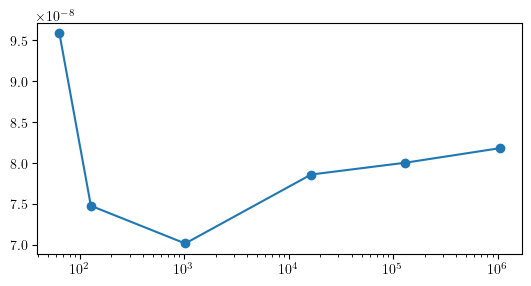

In [7]:
comptime_per_step=[]
comptime=   np.array(comptime)
nexp= len(alphas)
for i in range(nexp):
    comptime_per_step.append(comptime[i].sum() / NP / NSTEPS[i])
comptime_per_step = np.array(comptime_per_step)
fig,axis = plt.subplots(figsize=(8.25-2, 3))
axis.plot(NSTEPS, comptime_per_step, marker='o')
axis.set_xscale('log')


In [10]:
print("mean computation time per step", comptime_per_step.mean(), "s")

mean computation time per step 8.019092909495036e-08 s


# over all trends with computation time?

In [11]:
NP = np.logspace(1,4,4, dtype=int)
NSTEPS = np.logspace(2,5,4, dtype=int)
NPgrid, NSTEPSgrid = np.meshgrid(NP, NSTEPS)

In [25]:
np.sum(NPgrid*NSTEPSgrid)*comptime_per_step.mean()

np.float64(98.98134779140821)

In [26]:
mean_comptime_per_step = comptime_per_step.mean()
print("expected computation time for all combinations of NP and NSTEPS")
print(np.sum(NPgrid*NSTEPSgrid)*mean_comptime_per_step, "s")

expected computation time for all combinations of NP and NSTEPS
98.98134779140821 s


In [27]:
# lets get some computation time per step
alpha = 1/100
arguments = []
for i in range(len(NP)):
    for j in range(len(NSTEPS)):
        initialkinematics, staticgalaxy, integrationparameters = SPE.prepare_integration_arguments(NPgrid[i,j], NSTEPSgrid[i,j]/alpha, alpha)
        args = [initialkinematics, staticgalaxy, integrationparameters]
        arguments.append(args)

ncpu = mp.cpu_count()-freecpu
pool = mp.Pool(processes=ncpu)
results = pool.map(SPE.leapfrogtofinalpositions, arguments)

Process SpawnPoolWorker-46:
Traceback (most recent call last):
  File "/Users/sferrone/miniforge3/envs/thesis/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/sferrone/miniforge3/envs/thesis/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/sferrone/miniforge3/envs/thesis/lib/python3.11/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/sferrone/miniforge3/envs/thesis/lib/python3.11/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
           ^^^^^^^^^^^^^^^^
  File "/Users/sferrone/repos/phd-thesis-ferrone/demos/numericalError/starParticlesErr1.py", line 174, in leapfrogtofinalpositions
    xf, yf, zf = tstrippy.integrator.xf.copy(), tstrippy.integrator.yf.copy(), tstrippy.integrator.zf.copy()
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardI

KeyboardInterrupt: 